In [20]:
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib.image as mpimg
import numpy as np
from scipy import interpolate
import datetime
import pandas as pd
import matplotlib
%matplotlib inline
from scipy import spatial

In [195]:
def powerspec(data, dt):
    N = len(data)
    T = N*dt
    f = np.linspace(0,N/2+0.2,N/2+1.)/T
    
    X = np.fft.fft(data)*dt
    Gxx = X*np.conj(X)*2/T
    Gxx = np.abs(Gxx[:N/2+1])
    
    return Gxx, f

def interp(data):
    # 1d interpolation to fill in nan values
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]
    data[np.isnan(data)] = np.interp(x, xp, fp)
    return data

def lagcorr(data, tau):
    rho = 0.*np.array(tau)
    for ind,t in enumerate(tau):
        if t > 0:
            rho[ind] = np.nanmean(data[t:]*data[:-t])  # nanmean necessary?
            rho[ind] = rho[ind] / np.nanvar(data[t:-t])  # nanvar?
        else:
            rho[ind] = np.nanmean(data*data)
            rho[ind] = rho[ind] / np.nanvar(data)
    return rho

def interp_nn(data, coords, tree, radius):
    
    # Nearest neighbour search for interpolation
    # replace value with average of neighbours
    # MAKE SURE TO ADJUST WEIGHTING TO NEAREST NEIGHBOURS **********

    for i in range(data.shape[0]):  # iterate through stations      
        idxs = tree.query_ball_point(coords[i], radius)
        if len(idxs) < 1:
            print 'STOP'
        nearby = data[idxs]
        nans = np.where(np.isnan(data[i]))
        for j in nans[0]:
            data[i,j] = np.nanmean(nearby[:,j])
    return data

# Minute data

In [109]:
# Minute data, 4 Schools
mins, dc = np.loadtxt('/Users/kawebb/P411_git/MinuteData/DeepCoveNew.txt', unpack=True)
jb = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JamesBayNew.txt', usecols=([1]), unpack=True)
jm = np.loadtxt('/Users/kawebb/P411_git/MinuteData/JohnMuirNew.txt', usecols=([1]), unpack=True)
uvic = np.loadtxt('/Users/kawebb/P411_git/MinuteData/UVicISCNew.txt', usecols=([1]), unpack=True)

- john muir - hourdata 15
- james bay - hourdata 14
- uvic - hourdata 32
- deep cove - hourdata 6

In [117]:
# fill in nan values with linear interpolation
# THIS DOESNT SEEM TO WORK WITH THE FOURIER TRANSFORM
dc = interp(dc)
jb = interp(jb)
jm = interp(jm)
uvic = interp(uvic)

# remove mean
dc -= np.mean(dc)
jb -= np.mean(jb)
jm -= np.mean(jm)
uvic -= np.mean(uvic)

/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.
  app.launch_new_instance()
/Users/kawebb/venv/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: numpy boolean negative (the unary `-` operator) is deprecated, use the bitwise_xor (the `^` operator) or the logical_xor function instead.


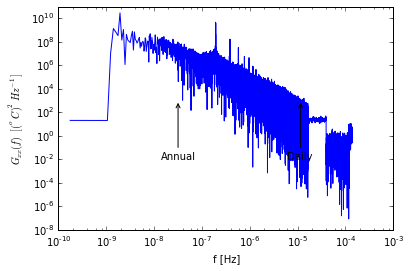

In [118]:
### Power spectrum - Assignment 4
dt = 3600 # s

dc_Gxx, f = powerspec(dc, dt)

plt.loglog(f, dc_Gxx)
plt.annotate('Annual', xy=(1./3600/24/365, 1.e3),  xycoords='data', xytext=(1./3600/24/365, 1.e-2), 
             textcoords='data', horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('Daily', xy=(1./3600/24, 1.e3),  xycoords='data', xytext=(1./3600/24, 1.e-2), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.xlabel('f [Hz]') ; plt.ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$') ; plt.show()

# We see a clear daily signal in the spectrum, and likely an annual signal too. 
# The spikes at higher frequencies are at harmonics of the daily frequency, and 
# are due to the fact that the temperature signal is not a precise sine-wave.

# Hourly data

## ideas:
- temperature differences inland vs coasts, seasonal
- seasonal variances
- east west
- yearly fluctuations
- interpolated missing data points from nearest neighbours

### power spactra
- correlations every 24h, 1yr etc
  - combine spectra to reduce noise and get  clearer peak
  - bandpass filtering
- variation in temperature (amplitude) varies more in summer than winter
- average summer temperature, winter, yearly -> linear equation, fit to majority of data

### to keep in mind:
- more data on coast than inland, how to keep track of percision?

# in polygon function
- use coastline to set limits on 2d interpolation

In [4]:
# Coastline
# 1 degree of latitude is 60 nautical miles, but 1 degree of longitude is only 60*cos(lat) 
# nautical miles, so it is useful to scale your x and y axis so the aspect ratio is 
# [1 cos(lat)], where "lat" is some latitude that is on the center of your plot. This area 
# is small enough that this approximation will be good enough - for larger areas you need 
# to choose a projection from a sphere onto a map (i.e. the "Mercator", "Azimuthal" etc projections).
coastfile = '/Users/kawebb/P411_git/Coast.txt'  # longitudes followed by latitudes
coasts = np.loadtxt(coastfile)
cstlng = coasts[:len(coasts)/2]
cstlat = coasts[len(coasts)/2:]

In [182]:
# Hourly data, many stations
# One-hour resolution temperature data is taken from the same network of 35 stations. 
# Data is on an even time grid, from 2009-01-01 08:00 UTC, with each row representing 
# a time, and each column a station. The first two rows are the longitude (degrees E) 
# and latitude (degrees N) of each station.
hourfile = '/Users/kawebb/P411_git/AllHourly.txt'
hourdata = np.loadtxt(hourfile)
data = hourdata[:,2:]
lng = hourdata[:,:1][:,0] - 360.  # -360 to fix that stations (0 to 360), coast (-180, 180).
lat = hourdata[:,1:2][:,0]

# deep cove is 0 (2?) (assignment 5)

In [183]:
### Make hour data
# The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333.
d = datetime.date(2012,1,1)
tstart = 733408.333
hours = np.arange(tstart, tstart+len(data[0])/24., 1./24.)  # step size is every hour
d.fromordinal(int(hours[0])), d.fromordinal(int(hours[-1]))  # three years worth of data

### First three measurements for all stations are nan, remove
data = data[:,3:]
hours = hours[3:]

### Handling nan values, identifying stations with not enough data

In [184]:
### Ignore data missing long spans of time
# 0, 11, 16, 19, 22, 23, 34 - missing lots
# 8, 10, 14, 17, 25, 30, 31 - missing a few months maybe

# Valid stations
ii = range(1,11)+range(12,16)+range(17,19)+range(20,22)+range(24,34)
ix = [0, 11, 16, 19, 22, 23, 34]

data = data[ii,:]
lng = lng[ii]
lat = lat[ii]

tree = spatial.KDTree(zip(lng.ravel(), lat.ravel()))
radius = 0.05  # in degrees
coords = np.dstack([lng, lat])[0]

data = interp_nn(data, coords, tree, radius)

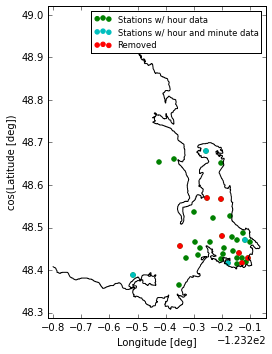

In [19]:
#latexify()
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.plot(cstlng, cstlat, '-k')
axs.scatter(lng, lat, marker='o', color='g', label='Stations w/ hour data')
i=[6, 15, 14, 32]
axs.scatter(lng[i], lat[i], marker='o', color='c', label='Stations w/ hour and minute data')
axs.scatter(lng[ix], lat[ix], marker='o', color='r', label='Removed')


axs.set_xlabel(r'Longitude [deg]') ; axs.set_ylabel(r'cos(Latitude [deg])')
axs.set_xlim(np.min(cstlng)-0.02, np.max(cstlng)+0.02)
axs.set_ylim(np.min(cstlat)-0.02, np.max(cstlat)+0.02)
axs.set_aspect(1/np.cos(48.6*np.pi/180.))
plt.tight_layout()
plt.legend(fontsize='small')
#plt.savefig('map_stations.png')
plt.show()

In [ ]:
# Power spectra of hourly data, dc
Nfft = 1024*4
dt = 1./24.
args = {'NFFT':Nfft, 'Fs':1./dt, 'noverlap':Nfft/2., 'window':mlab.window_hanning}

dc = data[0,:]
dc = dc[np.isfinite(dc)]

pp, f = mlab.psd(dc, **args)

plt.loglog(f, pp, label='Power spectra')
pltxlabel('f [Hz]') ; plt.ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$')

## Look for spatial patterns in the data using empiracle orthogonal functions

In [ ]:
### Lag correlation coefficient - Assignment 3

lag = np.arange(0,30*24)

rho = lagcorr(dc, lag)

x = lag/24.
plt.plot(x, rho)
plt.xlabel(r'$\tau [days]$') ; plt.ylabel(r'$\rho_{xy}(\tau)$') ; plt.show()

# There is a strong daily correlation, superimposed on a longer time scale 
#  weakening of the correlation as time gets further out.

# Do the same for winter and summer months

In [ ]:
### Power spectrum - Assignment 4

dt = 3600 # s

dc_Gxx, f = powerspec(dc, dt)

plt.loglog(f, dc_Gxx)
plt.annotate('Annual', xy=(1./3600/24/365, 1.e3),  xycoords='data', xytext=(1./3600/24/365, 1.e-2), 
             textcoords='data', horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.annotate('Daily', xy=(1./3600/24, 1.e3),  xycoords='data', xytext=(1./3600/24, 1.e-2), textcoords='data', 
            horizontalalignment='center', arrowprops=dict(arrowstyle="->"))
plt.xlabel('f [Hz]') ; plt.ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$') ; plt.show()

# We see a clear daily signal in the spectrum, and likely an annual signal too. 
# The spikes at higher frequencies are at harmonics of the daily frequency, and 
# are due to the fact that the temperature signal is not a precise sine-wave.

In [55]:
SPINE_COLOR = 'gray'
def latexify(fig_width=None, fig_height=None, columns=1):
    """
    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """
    assert(columns in [1,2])
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches
    if fig_height is None:
        golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES
    params = {'backend': 'ps',
              #'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              #'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }
    matplotlib.rcParams.update(params)
    
def format_axes(ax, xlabel, ylabel):
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)
    return ax